In [2]:
##------- 1. Load libraries & model
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from transformers import BertTokenizer, BertForMaskedLM, BertModel
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_score, confusion_matrix
from scipy.optimize import linear_sum_assignment
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [10]:
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove punctuation and special chars (keep apostrophes for words like "don't")
    text = re.sub(r'[^\w\s\']', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

In [12]:
# 1. Load and preprocess data with NaN handling
df = pd.read_csv('spam.csv', encoding='latin-1')
df = df[['text', 'target']].copy()

# Handle missing values
print(f"Missing values before cleaning: {df.isna().sum()}")
df = df.dropna()  # Remove rows with missing values
df = df[df['target'].isin(['ham', 'spam'])]  # Ensure only valid labels remain

# Clean text and convert labels
df['text'] = df['text'].str.lower().str.replace('[^\w\s]', '')
df['target'] = df['target'].map({'ham': 0, 'spam': 1})

# Verify no NaN values remain
assert not df['target'].isna().any(), "Target still contains NaN values"
assert not df['text'].isna().any(), "Text still contains NaN values"


Missing values before cleaning: text      0
target    0
dtype: int64


In [13]:
df['cleaned_text'] = df['text'].apply(clean_text)

In [14]:
# 2. Prepare Word2Vec embeddings
sentences = [text.split() for text in df['cleaned_text']]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

def get_embedding(text):
    words = text.split()
    words = [word for word in words if word in w2v_model.wv]
    if len(words) > 0:
        return np.mean(w2v_model.wv[words], axis=0)
    return np.zeros(100)

X = np.array([get_embedding(text) for text in df['cleaned_text']])
y = df['target'].values

In [15]:
# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# 4. Initialize models with NaN handling
models = {
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "GBM": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
}


In [17]:
# 5. Train and evaluate models
results = []
for name, model in models.items():
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        results.append((name, acc, y_pred))
        
        print(f"\n{name} Results:")
        print(classification_report(y_test, y_pred))
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))
    except Exception as e:
        print(f"\nError in {name}: {str(e)}")


Naive Bayes Results:
              precision    recall  f1-score   support

           0       0.94      0.58      0.71       965
           1       0.22      0.77      0.34       150

    accuracy                           0.60      1115
   macro avg       0.58      0.67      0.53      1115
weighted avg       0.85      0.60      0.66      1115

Confusion Matrix:
[[555 410]
 [ 34 116]]

Random Forest Results:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       965
           1       0.94      0.76      0.84       150

    accuracy                           0.96      1115
   macro avg       0.95      0.88      0.91      1115
weighted avg       0.96      0.96      0.96      1115

Confusion Matrix:
[[958   7]
 [ 36 114]]

GBM Results:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       965
           1       0.86      0.70      0.77       150

    accuracy                           0

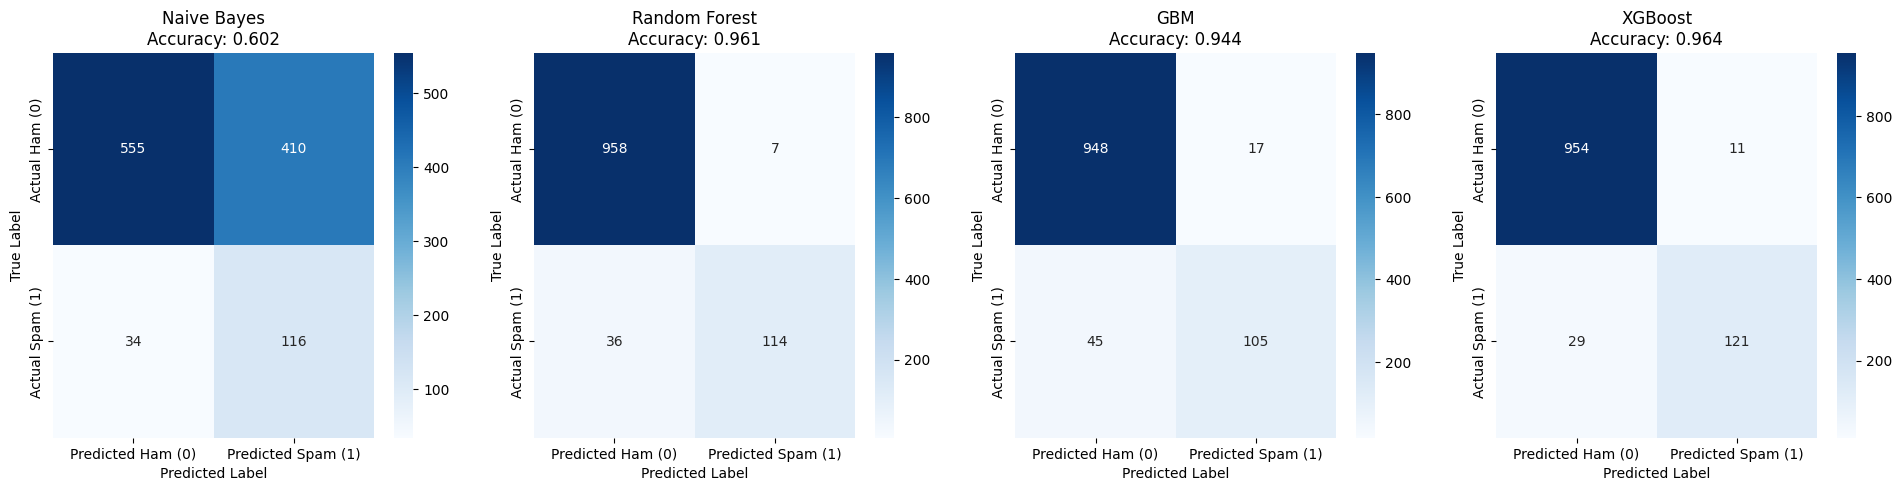

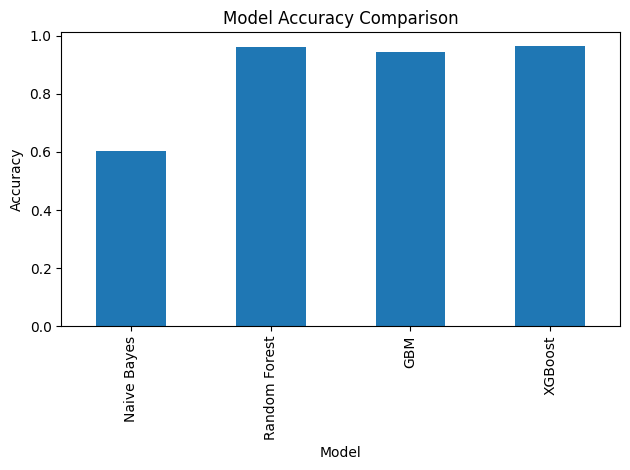

In [43]:
# 6. Visualization
if results:  # Only plot if we have successful results
    plt.figure(figsize=(30, 5))
    
    # Create results DataFrame correctly
    results_df = pd.DataFrame([(name, acc) for name, acc, _ in results], 
                             columns=['Model', 'Accuracy'])
    
    # # Confusion matrices
    # for i, (name, acc, y_pred) in enumerate(results):
    #     plt.subplot(1, 5, i+2)
    #     sns.heatmap(confusion_matrix(y_test, y_pred), 
    #                annot=True, fmt='d', cmap='Blues')
    #     plt.title(f'{name}\nAccuracy: {acc:.3f}')
    #     plt.xlabel('Predicted')
    #     plt.ylabel('Actual')

    # plt.tight_layout()
    # plt.show()

    # Confusion matrices with proper labeling
    for i, (name, acc, y_pred) in enumerate(results):
        plt.subplot(1, 5, i+2)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Predicted Ham (0)', 'Predicted Spam (1)'],
                   yticklabels=['Actual Ham (0)', 'Actual Spam (1)'])
        plt.title(f'{name}\nAccuracy: {acc:.3f}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.yticks(rotation=90)

        # Accuracy comparison
    results_df.set_index('Model').plot(kind='bar', legend=False)
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()
